In [31]:
from pathlib import Path
import os
import sys
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ultralytics import YOLO

In [32]:
repo_root = Path.cwd().resolve().parent if Path.cwd().name == "analyses" else Path.cwd().resolve()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

pretrained_dir = repo_root / "base_pretrained_models"
pretrained_dir.mkdir(parents=True, exist_ok=True)

model_arch_dir = repo_root / "model_architectures"
model_arch_dir.mkdir(parents=True, exist_ok=True)

print("repo_root:", repo_root)
print("pretrained_dir:", pretrained_dir)
print("model_arch_dir:", model_arch_dir)

repo_root: C:\Users\matma\Desktop\ITU\CV\ADVCV_final_project
pretrained_dir: C:\Users\matma\Desktop\ITU\CV\ADVCV_final_project\base_pretrained_models
model_arch_dir: C:\Users\matma\Desktop\ITU\CV\ADVCV_final_project\model_architectures


In [33]:
from model.model_loader import ModelLoader
config_v8m_path = repo_root / "configs" / "config.yaml"
config_p2_path = repo_root / "configs" / "config_targeting_small_objects.yaml"

with open(config_v8m_path, "r", encoding="utf-8") as f:
    config_v8m = yaml.safe_load(f)
with open(config_p2_path, "r", encoding="utf-8") as f:
    config_p2 = yaml.safe_load(f)

print("Using configs:")
print(" -", config_v8m_path)
print(" -", config_p2_path)


Using configs:
 - C:\Users\matma\Desktop\ITU\CV\ADVCV_final_project\configs\config.yaml
 - C:\Users\matma\Desktop\ITU\CV\ADVCV_final_project\configs\config_targeting_small_objects.yaml


In [34]:
import shutil

# Canonical checkpoint path
yolov8m_ckpt = pretrained_dir / "yolov8m.pt"

# One-time fallback sources from old repo layout
fallbacks = [
    repo_root / "analyses" / "yolov8m.pt",
    model_arch_dir / "yolov8m.pt",
]

if not yolov8m_ckpt.exists():
    for src in fallbacks:
        if src.exists():
            shutil.copy2(src, yolov8m_ckpt)
            print("Copied base checkpoint from:", src)
            break

# Last resort: let ultralytics download, then save canonical local copy
if not yolov8m_ckpt.exists():
    YOLO("yolov8m.pt").save(str(yolov8m_ckpt))
    print("Downloaded and saved base checkpoint:", yolov8m_ckpt)

# Force ModelLoader to use canonical local checkpoint
ModelLoader.YOLO_VARIANTS["yolov8m"] = str(yolov8m_ckpt)

print("Using base checkpoint:", yolov8m_ckpt)


Using base checkpoint: C:\Users\matma\Desktop\ITU\CV\ADVCV_final_project\base_pretrained_models\yolov8m.pt


In [35]:
# No file creation for yolov8m-p2.pt.
# For inspection we build P2 in memory from yaml and transfer from canonical yolov8m checkpoint.
print("P2 will be created in-memory via YOLO('yolov8m-p2.yaml').load(yolov8m_ckpt)")

P2 will be created in-memory via YOLO('yolov8m-p2.yaml').load(yolov8m_ckpt)


In [36]:
# Load models through the project pipeline (ModelLoader + YAML configs).
loader_v8m = ModelLoader(config_v8m)
loader_p2 = ModelLoader(config_p2)

model_v8m = loader_v8m.load_model()
model_p2 = loader_p2.load_model()

print("Loaded:")
print(" -", config_v8m.get("model", {}).get("name"))
print(" -", config_p2.get("model", {}).get("name"))


Loading pretrained model: C:\Users\matma\Desktop\ITU\CV\ADVCV_final_project\base_pretrained_models\yolov8m.pt

Model Information
  Model: yolov8m
  Total parameters: 25,902,640
  Trainable parameters: 0
  Trainable %: 0.00%

Loading pretrained model: yolov8m-p2.yaml
Building yolov8m-p2.yaml and transferring weights from C:\Users\matma\Desktop\ITU\CV\ADVCV_final_project\base_pretrained_models\yolov8m.pt
Transferred 319/629 items from pretrained weights

Model Information
  Model: yolov8m-p2
  Total parameters: 23,847,072
  Trainable parameters: 23,847,056
  Trainable %: 100.00%

Loaded:
 - yolov8m
 - yolov8m-p2


In [37]:
# Sanity check with canonical paths, no extra .pt writes.
m = YOLO(str(yolov8m_ckpt))
p2 = YOLO("yolov8m-p2.yaml").load(str(yolov8m_ckpt))  # in-memory only

m.model.requires_grad_(True)
p2.model.requires_grad_(True)

def n_params(y):
    total = sum(p.numel() for p in y.model.parameters())
    trainable = sum(p.numel() for p in y.model.parameters() if p.requires_grad)
    return total, trainable

print("v8m:", n_params(m), "layers:", len(m.model.model))
print("p2 :", n_params(p2), "layers:", len(p2.model.model))
print("v8m scale:", m.model.yaml.get("scale"), "nc:", m.model.yaml.get("nc"))
print("p2  scale:", p2.model.yaml.get("scale"), "nc:", p2.model.yaml.get("nc"))


Transferred 319/629 items from pretrained weights
v8m: (25902640, 25902640) layers: 23
p2 : (23847072, 23847072) layers: 29
v8m scale: None nc: 80
p2  scale: m nc: 80


In [38]:
# Build architecture tables from loaded models 
def architecture_table_from_loaded(yolo_model):
    core = yolo_model.model

    runtime_rows = []
    for idx, layer in enumerate(core.model):
        runtime_rows.append({
            "idx": idx,
            "from_runtime": str(getattr(layer, "f", None)),
            "module_runtime": layer.__class__.__name__,
            "params_total": int(sum(p.numel() for p in layer.parameters())),
            "params_trainable": int(sum(p.numel() for p in layer.parameters() if p.requires_grad)),
        })
    runtime_df = pd.DataFrame(runtime_rows)

    yaml_rows = []
    cfg = getattr(core, "yaml", {}) or {}
    defs = cfg.get("backbone", []) + cfg.get("head", [])
    for idx, entry in enumerate(defs):
        if isinstance(entry, (list, tuple)) and len(entry) >= 4:
            yaml_rows.append({
                "idx": idx,
                "from_yaml": str(entry[0]),
                "repeats": entry[1],
                "module_yaml": str(entry[2]),
                "args_yaml": str(entry[3]),
            })
    yaml_df = pd.DataFrame(yaml_rows)

    return yaml_df.merge(runtime_df, on="idx", how="outer").sort_values("idx").reset_index(drop=True)

v8m_df = architecture_table_from_loaded(model_v8m)
p2_df = architecture_table_from_loaded(model_p2)

print("YOLOv8m architecture table")
display(v8m_df)


YOLOv8m architecture table


,idx,from_yaml,repeats,module_yaml,args_yaml,from_runtime,module_runtime,params_total,params_trainable
0,0,-1,1,Conv,"[64, 3, 2]",-1,Conv,1392,0
1,1,-1,1,Conv,"[128, 3, 2]",-1,Conv,41664,0
2,2,-1,3,C2f,"[128, True]",-1,C2f,111360,0
3,3,-1,1,Conv,"[256, 3, 2]",-1,Conv,166272,0
4,4,-1,6,C2f,"[256, True]",-1,C2f,813312,0
5,5,-1,1,Conv,"[512, 3, 2]",-1,Conv,664320,0
6,6,-1,6,C2f,"[512, True]",-1,C2f,3248640,0
7,7,-1,1,Conv,"[768, 3, 2]",-1,Conv,1991808,0
8,8,-1,3,C2f,"[768, True]",-1,C2f,3985920,0
9,9,-1,1,SPPF,"[768, 5]",-1,SPPF,831168,0


So we can consider the components of the YOLOv8m model to correspond to these indexes:

Backbone: From layer index 0 to 9

Neck: From layer index 10 to 21

Detection head: Layer index 22


[Source from the Ultralytics docs](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/models/v8/yolov8.yaml)

In [39]:
print("YOLOv8m-p2 architecture table")
display(p2_df)

YOLOv8m-p2 architecture table


,idx,from_yaml,repeats,module_yaml,args_yaml,from_runtime,module_runtime,params_total,params_trainable
0,0,-1,1,Conv,"[64, 3, 2]",-1,Conv,1392,1392
1,1,-1,1,Conv,"[128, 3, 2]",-1,Conv,41664,41664
2,2,-1,3,C2f,"[128, True]",-1,C2f,111360,111360
3,3,-1,1,Conv,"[256, 3, 2]",-1,Conv,166272,166272
4,4,-1,6,C2f,"[256, True]",-1,C2f,813312,813312
5,5,-1,1,Conv,"[512, 3, 2]",-1,Conv,664320,664320
6,6,-1,6,C2f,"[512, True]",-1,C2f,3248640,3248640
7,7,-1,1,Conv,"[1024, 3, 2]",-1,Conv,1991808,1991808
8,8,-1,3,C2f,"[1024, True]",-1,C2f,3985920,3985920
9,9,-1,1,SPPF,"[1024, 5]",-1,SPPF,831168,831168


In [40]:
detect = next(m for m in model_p2.model.model if m.__class__.__name__ == "Detect")

df_detect_inputs = pd.DataFrame({
    "from_idx": list(detect.f),                     
    "stride": [int(s) for s in detect.stride.tolist()]  
})

df_detect_inputs["role"] = df_detect_inputs["stride"].map(
    {4: "P2 (new)", 8: "P3", 16: "P4", 32: "P5"}
)

display(df_detect_inputs)


,from_idx,stride,role
0,18,4,P2 (new)
1,21,8,P3
2,24,16,P4
3,27,32,P5


The detection layer (`Detect`) receives several feature maps at different resolutions, it's is one module receiving 4 inputs:
- stride 4 (P2) = very fine detail, small objects
- stride 8 (P3)
- stride 16 (P4)
- stride 32 (P5) = coarse detail, large objects

Each index points to a different neck output tensor with a different spatial scale.  

We can see that by receiving input feature maps which are not too coarse yet and uses stride 4 the P2 takes into account an additional high-resolution fine grained scale

---

So we can consider the components of the YOLOv8m-p2 model to correspond to these indexes:

Backbone: From layer index 0 to 9

Neck: From layer index 10 to 27

Detection head with additional p2: Layer index 28

[Source from the Ultralytics docs](https://github.com/ultralytics/ultralytics/blob/main/ultralytics/cfg/models/v8/yolov8-p2.yaml)

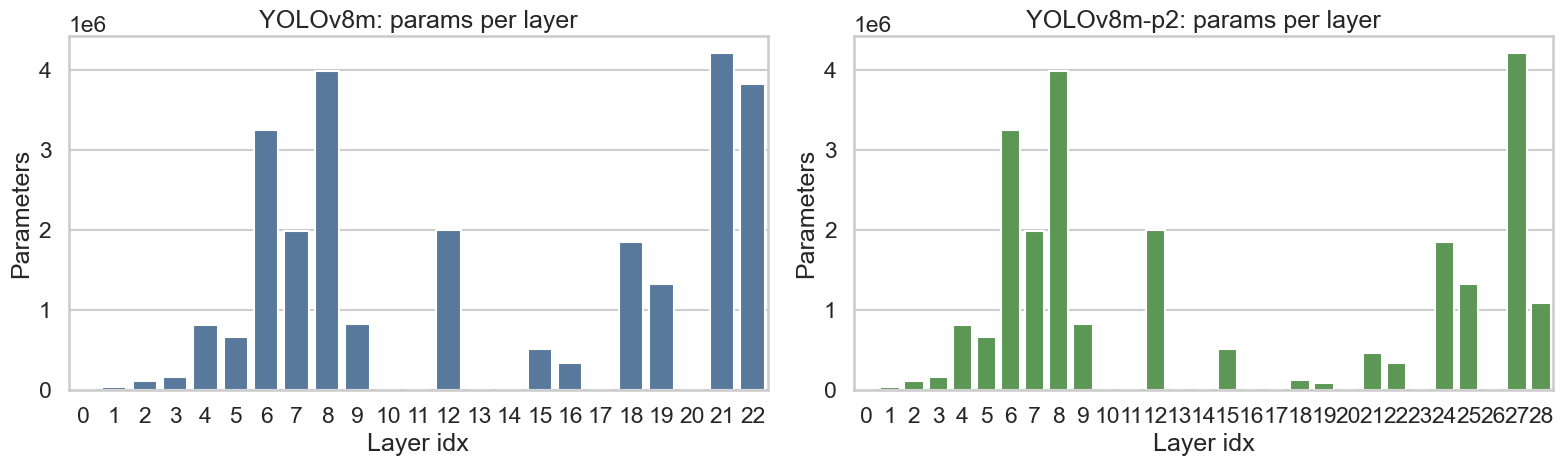

In [41]:
# Visualization of parameter count per layer index
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=False)

sns.barplot(data=v8m_df, x="idx", y="params_total", ax=axes[0], color="#4C78A8")
axes[0].set_title("YOLOv8m: params per layer")
axes[0].set_xlabel("Layer idx")
axes[0].set_ylabel("Parameters")

sns.barplot(data=p2_df, x="idx", y="params_total", ax=axes[1], color="#54A24B")
axes[1].set_title("YOLOv8m-p2: params per layer")
axes[1].set_xlabel("Layer idx")
axes[1].set_ylabel("Parameters")

plt.tight_layout()
plt.show()


In [42]:
# Save tables to model_architectures
v8m_csv = model_arch_dir / "inspect_yolov8m_notebook.csv"
p2_csv = model_arch_dir / "inspect_yolov8m_p2_notebook.csv"

v8m_df.to_csv(v8m_csv, index=False)
p2_df.to_csv(p2_csv, index=False)

print("Saved:")
print(" -", v8m_csv)
print(" -", p2_csv)


Saved:
 - C:\Users\matma\Desktop\ITU\CV\ADVCV_final_project\model_architectures\inspect_yolov8m_notebook.csv
 - C:\Users\matma\Desktop\ITU\CV\ADVCV_final_project\model_architectures\inspect_yolov8m_p2_notebook.csv


Exact trainable/frozen parameter accounting (pipeline-matched)

This section computes trainable and frozen parameters following the training pipeline.
Reasoning:

1. In `scripts/run_experiments.sh`, each run is defined by a `--freeze N` value.
2. In `main.py`, that CLI value is written into `config['model']['freeze_layers']`.
3. In `utils/training.py`, `train_args['freeze'] = config['model']['freeze_layers']` is passed to Ultralytics.
4. Ultralytics then freezes parameters that belong to layers `0..N-1` (using `model.<idx>.` parameter prefixes), and it also keeps the DFL conv weights frozen (this matches the training logs).

So, instead of inferring only from architecture tables, we build a **parameter-level dataframe** (`name`, `numel`, `layer_idx`, `is_trainable`) after applying the same freeze rule, then aggregate to get exact totals.


In [43]:
# Compact pipeline-matched trainable/frozen summary (only what is needed for plots/report)

import copy
import pandas as pd

freeze_plan = [
    {"run_name": "full_finetune",   "model_key": "yolov8m",    "freeze_layers": 0},
    {"run_name": "freeze_backbone", "model_key": "yolov8m",    "freeze_layers": 10},
    {"run_name": "head_only",       "model_key": "yolov8m",    "freeze_layers": 22},
    {"run_name": "yolov8m_p2_full", "model_key": "yolov8m-p2", "freeze_layers": 0},
]

# Load once, reuse models (reset requires_grad per strategy)
model_bank = {
    "yolov8m": ModelLoader(copy.deepcopy(config_v8m)).load_model(),
    "yolov8m-p2": ModelLoader(copy.deepcopy(config_p2)).load_model(),
}

rows = []
frozen_debug_rows = []  # only for full-finetune runs

for spec in freeze_plan:
    run_name = spec["run_name"]
    model_key = spec["model_key"]
    freeze_layers = int(spec["freeze_layers"])

    yolo_model = model_bank[model_key]
    yolo_model.model.requires_grad_(True)

    freeze_prefixes = tuple(f"model.{i}." for i in range(freeze_layers))

    total_params = 0
    trainable_params = 0

    for pname, p in yolo_model.model.named_parameters():
        freeze_this = pname.startswith(freeze_prefixes) or (".dfl.conv.weight" in pname)
        p.requires_grad = not freeze_this

        n = int(p.numel())
        total_params += n
        if p.requires_grad:
            trainable_params += n
        elif run_name in ("full_finetune", "yolov8m_p2_full"):
            frozen_debug_rows.append({
                "run_name": run_name,
                "param_name": pname,
                "numel": n,
            })

    frozen_params = total_params - trainable_params
    trainable_pct = 100.0 * trainable_params / total_params

    rows.append({
        "run_name": run_name,
        "model_name": model_key,
        "freeze_layers": freeze_layers,
        "total_params": total_params,
        "trainable_params": trainable_params,
        "frozen_params": frozen_params,
        "trainable_pct": trainable_pct,
    })

df_summary_exact = pd.DataFrame(rows)
df_frozen_debug = pd.DataFrame(frozen_debug_rows)

display(df_summary_exact.sort_values(["model_name", "freeze_layers", "run_name"]))

# Save only one CSV (optional)
summary_csv = model_arch_dir / "freeze_parameter_exact.csv"
df_summary_exact.to_csv(summary_csv, index=False)
print("Saved:", summary_csv)


Loading pretrained model: C:\Users\matma\Desktop\ITU\CV\ADVCV_final_project\base_pretrained_models\yolov8m.pt

Model Information
  Model: yolov8m
  Total parameters: 25,902,640
  Trainable parameters: 0
  Trainable %: 0.00%

Loading pretrained model: yolov8m-p2.yaml
Building yolov8m-p2.yaml and transferring weights from C:\Users\matma\Desktop\ITU\CV\ADVCV_final_project\base_pretrained_models\yolov8m.pt
Transferred 319/629 items from pretrained weights

Model Information
  Model: yolov8m-p2
  Total parameters: 23,847,072
  Trainable parameters: 23,847,056
  Trainable %: 100.00%



,run_name,model_name,freeze_layers,total_params,trainable_params,frozen_params,trainable_pct
0,full_finetune,yolov8m,0,25902640,25902624,16,99.999938
1,freeze_backbone,yolov8m,10,25902640,14046768,11855872,54.229098
2,head_only,yolov8m,22,25902640,3822000,22080640,14.755253
3,yolov8m_p2_full,yolov8m-p2,0,23847072,23847056,16,99.999933


Saved: C:\Users\matma\Desktop\ITU\CV\ADVCV_final_project\model_architectures\freeze_parameter_exact.csv


The 16 frozen here is the Detect.dfl.conv.weight, in Ultralytics even with freeze=0 it cannot be trained.

That tensor has 16 values (reg_max=16), so frozen_params = 16.


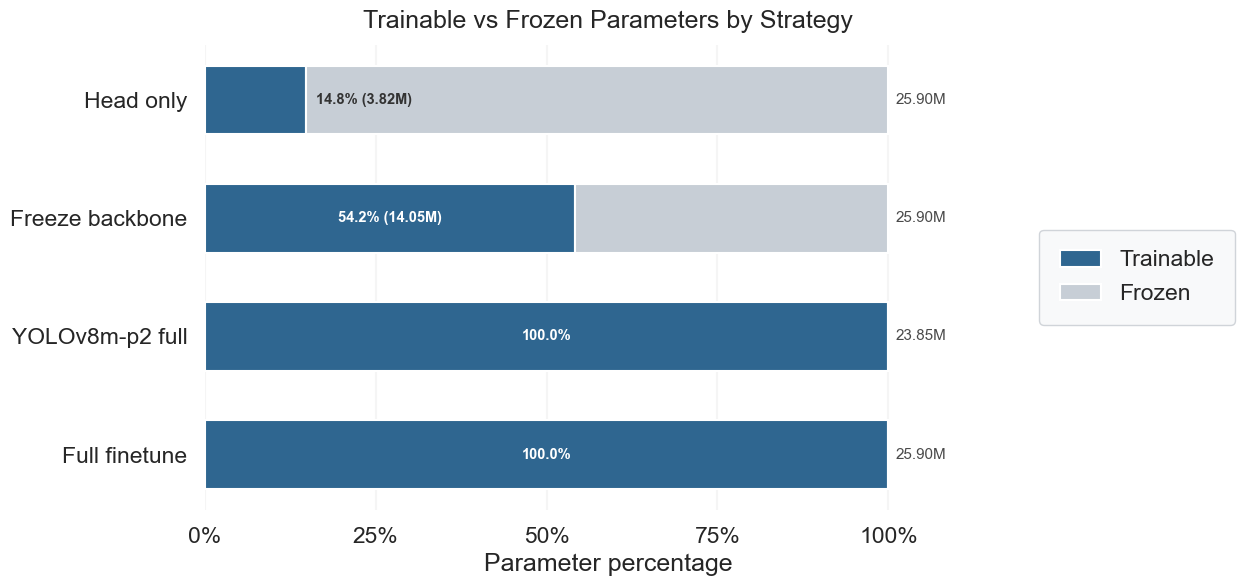

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["axes.facecolor"] = "white"

plot_df = df_summary_exact.copy()

label_map = {
    "head_only": "Head only",
    "freeze_backbone": "Freeze backbone",
    "full_finetune": "Full finetune",
    "yolov8m_p2_full": "YOLOv8m-p2 full",
}
plot_df["label"] = plot_df["run_name"].map(label_map).fillna(plot_df["run_name"])

# increasing order by trainable %
plot_df = plot_df.sort_values("trainable_pct", ascending=True).reset_index(drop=True)

plot_df["trainable_frac"] = plot_df["trainable_params"] / plot_df["total_params"]
plot_df["frozen_frac"] = plot_df["frozen_params"] / plot_df["total_params"]
plot_df["total_M"] = plot_df["total_params"] / 1e6

train_color = "#2F6690"   
frozen_color = "#C7CED6"  

fig, ax = plt.subplots(figsize=(12.8, 6.2))
y = np.arange(len(plot_df))

ax.barh(y, plot_df["trainable_frac"], height=0.58, color=train_color, edgecolor="white", label="Trainable")
ax.barh(
    y,
    plot_df["frozen_frac"],
    left=plot_df["trainable_frac"],
    height=0.58,
    color=frozen_color,
    edgecolor="white",
    label="Frozen",
)

ax.invert_yaxis()

# show % + trainable params only for the other two strategies
show_trainable_num_for = {"freeze_backbone", "head_only"}

for i, row in plot_df.iterrows():
    t = row["trainable_frac"]
    trainable_M = row["trainable_params"] / 1e6

    if row["run_name"] in show_trainable_num_for:
        txt = f"{row['trainable_pct']:.1f}% ({trainable_M:.2f}M)"
    else:
        txt = f"{row['trainable_pct']:.1f}%"

    if t >= 0.18:
        ax.text(t / 2, i, txt, ha="center", va="center",
                color="white", fontsize=10.5, fontweight="semibold")
    else:
        ax.text(t + 0.015, i, txt, ha="left", va="center",
                color="#333333", fontsize=10.5, fontweight="semibold")

    ax.text(1.01, i, f"{row['total_M']:.2f}M", ha="left", va="center",
            fontsize=11, color="#4A4A4A")


ax.set_yticks(y)
ax.set_yticklabels(plot_df["label"])

ax.set_xlim(0, 1.18)
ax.set_xticks([0, 0.25, 0.50, 0.75, 1.00])
ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"])

ax.set_xlabel("Parameter percentage")
ax.set_title("Trainable vs Frozen Parameters by Strategy", pad=12)

ax.grid(axis="x", linestyle="-", alpha=0.18)
ax.grid(axis="y", visible=False)

# legend outside with proper spacing
leg = ax.legend(
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=True,
    fancybox=True,
    framealpha=1.0,
    borderpad=0.9,
    labelspacing=0.6,
    handlelength=1.8,
)
leg.get_frame().set_facecolor("#F8F9FA")
leg.get_frame().set_edgecolor("#D0D4D9")
leg.get_frame().set_linewidth(1.0)

sns.despine(left=True, bottom=True)
plt.subplots_adjust(right=0.80)
plt.tight_layout()
plt.show()


In [45]:
display(df_frozen_debug)
display(
    df_frozen_debug.groupby("run_name", as_index=False)["numel"]
    .sum()
    .rename(columns={"numel": "non_trainable_params_total"})
)

,run_name,param_name,numel
0,full_finetune,model.22.dfl.conv.weight,16
1,yolov8m_p2_full,model.28.dfl.conv.weight,16


,run_name,non_trainable_params_total
0,full_finetune,16
1,yolov8m_p2_full,16
